## Trip Duration Prediction using Bayesian Neural Networks and TensorFlow 2.0

Neural networks are great for generating predictions when you have lots of training data, but by default they don't report the uncertainty of their estimates.  Uncertainty information can be super important for applications where your risk function isn't linear.  For example, suppose you're working for a logistics company, and need to choose a shipping company to ship a part which *needs* to arrive by Friday - but you don't really care how early it arrives, as long as it arrives by the deadline.  A vanilla neural network would only give you the best estimate for each company: for example, the shipment arrival time estimate for company A might be Wednesday, and Thursday for company B.  But choosing company A just because the estimated arrival time is sooner could be a mistake!  Suppose the uncertainty as to the model's estimate is much larger for company A than B: even if the *expected* arrival time is earlier for company A, it could be that company B is 99% likely to get the shipment there by Friday, while company A is only 90% likely to get it there by Friday!  My point is: often uncertainty information can really help with decision-making.

![Shipping Example](http://drive.google.com/uc?export=view&id=1dYAfnvB1wwjriK2-aKsLDyN4tk7q9Gx7)

In this post we'll build a Bayesian neural network which has two "heads" - that is, two endpoints of the network.  One head will predict the *value* of the estimate, and the other to predict the *uncertainty* of that estimate.  This dual-headed structure allows the model to dynamically adjust its uncertainty estimates, and because it's a Bayesian network, also captures uncertainty as to what the network parameters should be, leading to more accurate uncertainty estimates.

![Dual headed net](http://drive.google.com/uc?export=view&id=1MPspM2UhxEziX924MWX8RmGe6Sk1ovg8)

Using this network, we'll predict taxi trip durations using taxi trip data from [New York City's Open Data](http://opendata.cityofnewyork.us/), which is hosted as a public dataset [on Google BigQuery](http://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-tlc-trips).  We'll be using some simple SQL and [google-cloud-bigquery](http://pypi.org/project/google-cloud-bigquery/) to load the data; [TensorFlow 2.0](http://www.tensorflow.org/beta/), [TensorFlow Probability](http://www.tensorflow.org/probability), and [CatBoost](http://catboost.ai) to do the modeling; [Vaex](http://github.com/vaexio/vaex) for visualization; as well as the numpy/pandas/matplotlib/sklearn/seaborn stack.

**Outline**

- [Data](#data)
- [Baseline Models](#baseline-models)
- [Vanilla Neural Network](#vanilla-neural-network)
- [Simple Bayesian Neural Network](#simple-bayesian-neural-network)
- [Dual-headed Bayesian Density Network](#dual-headed-bayesian-density-network)
- [Model Evaluation](#model-evaluation)

First let's install and import the packages we'll use.

In [1]:
# Install packages
!pip install -q --upgrade tf-nightly-gpu-2.0-preview
!pip install -q tfp-nightly
!pip install -q catboost
!pip install -q --pre vaex
# pip install -q google-cloud-bigquery #TODO: have to install if not using kaggle kernels

ERROR: spyder 3.3.5 requires pyqt5<5.13; python_version >= "3", which is not installed.
ERROR: spyder 3.3.5 requires pyqtwebengine<5.13; python_version >= "3", which is not installed.
ERROR: gym 0.13.1 has requirement cloudpickle~=1.2.0, but you'll have cloudpickle 1.1.1 which is incompatible.


In [2]:
# Packages
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import vaex

from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import cross_val_score, cross_val_predict

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow_probability.python.math import random_rademacher
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.optimizers import Adam

from catboost import CatBoostRegressor

from google.cloud import bigquery

# Settings
sns.set()
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
%config InlineBackend.figure_format = 'svg'
np.random.seed(12345)
tf.random.set_seed(12345)

## Data

We'll be predicting taxi trip durations from the start and end locations of the ride, as well as the time of day when the trip started.  New York City releases a lot of their data [publicly](http://opendata.cityofnewyork.us/), including information about taxi rides, which is hosted as a public dataset [on Google BigQuery](http://console.cloud.google.com/marketplace/details/city-of-new-york/nyc-tlc-trips)!  Let's load the first several million rows from the yellow taxi trip dataset using Google BigQuery:

In [3]:
%%time

# SQL Query to retreive the data
# There are 131M records in full dataset!
QUERY = """
    SELECT
        pickup_datetime,
        dropoff_datetime,
        pickup_longitude,
        pickup_latitude,
        dropoff_longitude,
        dropoff_latitude
    FROM `bigquery-public-data.new_york.tlc_yellow_trips_2016`
    LIMIT 1000000;
"""

# Load a subset of the dataset
data = bigquery.Client().query(QUERY).to_dataframe()

Using Kaggle's public dataset BigQuery integration.
CPU times: user 30 s, sys: 1.72 s, total: 31.8 s
Wall time: 1min 35s


Now we can clean and process the data for modeling.  I've done a more comprehensive exploratory data analysis in [a previous post](https://brendanhasz.github.io/2018/12/15/quantile-regression.html), so we'll skip the EDA here and just clean the data.

In [4]:
# Drop rows with empty values
data.dropna(inplace=True)

# Compute trip duration in seconds
data['trip_duration'] = (data['dropoff_datetime'] - data['pickup_datetime']).dt.seconds

# Extract useful time information
data['min_of_day'] = (60*data['pickup_datetime'].dt.hour + 
                       data['pickup_datetime'].dt.minute)
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear

# Remove datetime columns
data.drop('pickup_datetime', axis=1, inplace=True)
data.drop('dropoff_datetime', axis=1, inplace=True)

# Function to remove rows outside range
def clip(df, a, b, col):
    for c in col:
        df = df[(df[c]>a) & (df[c]<b)]
    return df

# Remove outliers
data = clip(data, 1, 4*3600, ['trip_duration'])
data = clip(data,  -75, -72.5,
             ['pickup_longitude', 'dropoff_longitude'])
data = clip(data, 40, 41.5,
             ['pickup_latitude', 'dropoff_latitude'])

# Transform target column
data['trip_duration'] = np.log(data['trip_duration'])

# Normalize data
data = (data - data.mean()) / data.std()

# Cast down to float32
data = data.astype('float32')

# Shuffle
data = data.sample(frac=1)

# Separate in- from dependent variables
x_taxi = data.drop('trip_duration', axis=1)
y_taxi = data['trip_duration']

Let's take a look at the cleaned data table and the distributions of the independent variables.

In [5]:
x_taxi.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,min_of_day,day_of_week,day_of_year
117066,-0.338226,0.416978,-0.257115,0.657103,-0.144256,-1.043355,-1.683405
207646,0.059577,0.099480,-0.126010,-0.272038,-0.084623,1.513639,-0.501515
369350,-0.227693,1.105543,0.110912,0.423541,-0.623915,-1.554753,0.195994
464636,4.665457,-3.865332,0.208559,-2.863754,-1.915106,-1.554753,1.552260
297599,-0.285498,-0.636781,-0.164330,-0.023157,-0.517612,-1.554753,1.552260


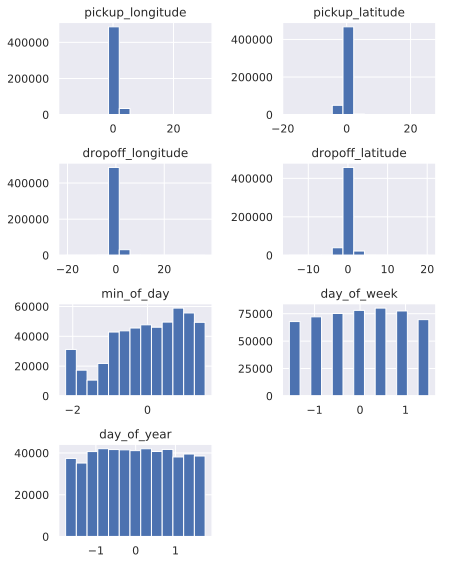

In [6]:
# Plot feature distributions
plt.figure(figsize=(6.4, 8))
for i in range(7):
    plt.subplot(4, 2, i+1)
    plt.hist(x_taxi.iloc[:, i], 13)
    plt.title(x_taxi.columns[i])
plt.tight_layout()
plt.show()

The dependent variable (our "target") will be the normalized duration of the taxi trip:

Text(0.5, 0, 'Normalized Trip Duration')

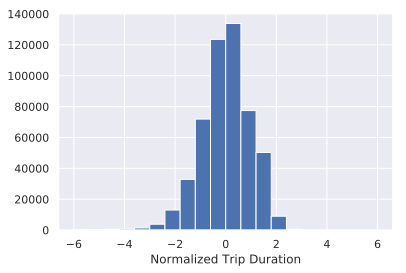

In [7]:
# Plot trip duration distribution
plt.hist(y_taxi, bins=np.linspace(-6, 6, 21))
plt.xlabel('Normalized Trip Duration')

## Baseline Models

Before we start messing with any fancy neural networks, let's evaluate the performance of some simple baseline models.  We want to see how much better than simple baselines the neural network performs (if it's better at all!), and also how much slower training the network is than those baselines.  First, let's make a function to evaluate any model on the data using cross-validation.  We'll use the mean absolute error as our metric, and by default will use 3-fold cross validation to evaluate the MAE.

In [8]:
# Make Mean Absolute Error scorer
mae_scorer = make_scorer(mean_absolute_error)

# Function to print cross-validated mean abs deviation
def cv_mae(regressor, x, y, cv=3, scorer=mae_scorer):
    scores = cross_val_score(regressor, 
                             x, y, cv=cv,
                             scoring=scorer)
    print('MAE:', scores.mean())

How well can we do if we just predict the mean duration for every trip?

In [9]:
# MAE from predicting just the mean
cv_mae(DummyRegressor(), x_taxi, y_taxi)

MAE: 0.7627771894137064


OK, so the MAE of our predictions from any reasonable model should definitely be better than ~0.76.

What about if we compute the distance between the pickup and dropoff locations, and just do an [isotonic regression](http://en.wikipedia.org/wiki/Isotonic_regression) using that one variable?

In [10]:
%%time

# Distance between pickup and dropoff locations
dist = np.sqrt(
    np.power(x_taxi['pickup_longitude'] -
             x_taxi['dropoff_longitude'], 2) + 
    np.power(x_taxi['pickup_latitude'] - 
             x_taxi['dropoff_latitude'], 2))

# MAE from using just distance as predictor
cv_mae(IsotonicRegression(out_of_bounds='clip'), 
       dist, y_taxi)

MAE: 0.45339752237002057
CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 406 ms


That's a lot better than just predicting the mean, and the model uses only one variable.  Note also that it's really fast to train.

How about if we use a gradient-boosted decision tree ensemble?  Let's use [CatBoost](http://catboost.ai) to predict the ride durations:

In [11]:
%%time

# MAE using CatBoost
cv_mae(CatBoostRegressor(verbose=False, depth=9), x_taxi, y_taxi)

MAE: 0.33508319699739375
CPU times: user 8min 33s, sys: 52.4 s, total: 9min 25s
Wall time: 5min 11s


Again, much better than the simpler baseline models.  Now the real question is, can a neural network beat CatBoost?

## Vanilla Neural Network

Before we make a Bayesian neural network, let's get a *normal* neural network up and running to predict the taxi trip durations.  We'll use [Keras](http://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras) and [TensorFlow 2.0](http://www.tensorflow.org/beta/).  Of course, Keras works pretty much exactly the same way with TF 2.0 as it did with TF 1.0.

Let's set some neural-network-specific settings which we'll use for all the neural networks in this post (including the Bayesian neural nets later one).

In [12]:
# Batch size
BATCH_SIZE = 1024

# Number of training epochs
EPOCHS = 100

# Learning rate
L_RATE = 1e-4

# Proportion of samples to hold out
VAL_SPLIT = 0.2

Now we can build the network using Keras's [Sequential](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Sequential) model.  We'll make a network with 4 hidden layers, and which outputs a single prediction as to the trip duration.

![Vanilla neural network](http://drive.google.com/uc?export=view&id=1e3uw9SYoOPCeW10_zB86FVEsR4_UsyXt)

It also uses [batch normalization](http://arxiv.org/abs/1502.03167) and [dropout](http://jmlr.org/papers/v15/srivastava14a.html) at each of the hidden layers:

In [13]:
# Multilayer dense neural network
D = x_taxi.shape[1]
model = Sequential([
    Dense(512, use_bias=False, input_shape=(D,)),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(128, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(64, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(32, use_bias=False),
    BatchNormalization(),
    ReLU(),
    Dropout(0.1),
    Dense(1)
])

After compiling the model,

In [14]:
# Compile the model with MAE loss
model.compile(tf.keras.optimizers.Adam(lr=L_RATE),
              loss='mean_absolute_error')

We can fit it to the taxi trip duration data:

In [15]:
%%time

# Fit the model
history = model.fit(x_taxi, y_taxi,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=VAL_SPLIT,
                    verbose=0)

CPU times: user 5min 5s, sys: 31.9 s, total: 5min 37s
Wall time: 4min 11s


Let's look at the validation error over the course of training.

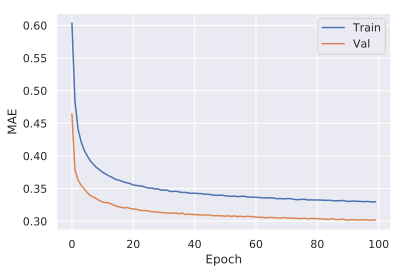

In [16]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.show()

That's a bit better than CatBoost!  Also note that the validation error is less than the training error - this is because we used dropout during training (and not during evaluation of the validation data). But again, with this network we don't get any uncertainty information, just point estimates:

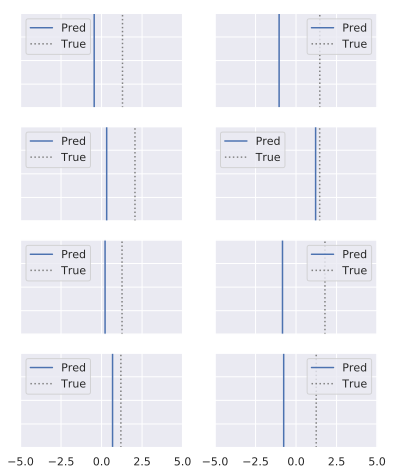

In [17]:
# Make predictions (tautological)
preds = model.predict(x_taxi)

# Plot true vs predicted durations
plt.figure(figsize=(6.4, 8))
for i in range(8):
    plt.subplot(4,2,i+1)
    plt.axvline(preds[i], label='Pred')
    plt.axvline(y_taxi[i], ls=':', color='gray', label='True')
    plt.xlim([-5, 5])
    plt.legend()
    plt.gca().get_yaxis().set_ticklabels([])
    if i<6:
        plt.gca().get_xaxis().set_ticklabels([])

Next we'll make a Bayesian neural network which includes an observation distribution, and so we'll be able to measure the uncertainty of its estimates.

## Simple Bayesian Neural Network

Before creating a Bayesian neural network with two heads, we'll create a network with just one.  This network will generate predictions just like the previous, non-Bayesian net, but will also have a parameter which estimates the overall level of uncertainty (sigma in the figure below).

![Single headed net](http://drive.google.com/uc?export=view&id=1oLxktWxQRt6DcJkMSe6CZOh2A-IJ42Jo)

It's difficult to fit a Bayesian neural network using Keras, because the loss isn't a simple function of the true vs predicted target values: with a Bayesian neural network we'll be using variational inference, which depends on the true target value, the predictive distribution, and the Kullback–Leibler divergences between the parameter's variational posteriors and their priors.

So, we'll do it in "raw" TensorFlow.  The recommended way to feed data into a model in TensorFlow 2.0 is using TF's [dataset API](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset), as opposed to the old `feed_dict` mechanism.  Let's build a TensorFlow Dataset which contains the taxi data:

In [18]:
# Split data randomly into training + validation
tr_ind = np.random.choice([False, True],
                          size=x_taxi.shape[0],
                          p=[VAL_SPLIT, 1.0-VAL_SPLIT])
x_train = x_taxi[tr_ind].values
y_train = y_taxi[tr_ind].values
x_val = x_taxi[~tr_ind].values
y_val = y_taxi[~tr_ind].values
N_train = x_train.shape[0]
N_val = x_val.shape[0]

# Make y 2d
y_train = np.expand_dims(y_train, 1)
y_val = np.expand_dims(y_val, 1)

# Make a TensorFlow Dataset from training data
data_train = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(BATCH_SIZE)

# Make a TensorFlow Dataset from validation data
data_val = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(N_val)

Also, we'll want to create a function which uses [Xavier initialization](http://proceedings.mlr.press/v9/glorot10a.html) to initialize the weights of the network.

In [19]:
# Xavier initializer
def xavier(shape):
    return tf.random.truncated_normal(
        shape, 
        mean=0.0,
        stddev=np.sqrt(2/sum(shape)))

Now let's create a class which represents one fully-connected Bayesian neural network layer, using the [Keras functional API (aka subclassing)](https://www.tensorflow.org/beta/guide/keras/functional).  We can instantiate this class to create one layer, and `__call__`ing that object performs the forward pass of the data through the layer.  We'll use TensorFlow Probability distribution objects to represent the prior and posterior distributions, and we'll give the class a `losses` property which returns the sum of the Kullback–Leibler divergence between the posterior distributions and their priors, so that we can fit the weights via stochastic variational inference.

Side note: I was going to use TensorFlow Probability's [DenseFlipout layer](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/DenseFlipout) here, but unfortunately it seems it doesn't fully support TensorFlow 2.0's eager execution yet!  The forward pass through the layer is fine, but the KL loss doesn't get updated.  So, we'll just build a Dense variational layer here manually, which isn't really all that bad using other aspects of TensorFlow Probability and the functional API.

In [20]:
class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    weight : tensorflow_probability.distributions.Normal
        Variational distributions for the network weights
    bias : tensorflow_probability.distributions.Normal
        Variational distributions for the network biases
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """

    def __init__(self, d_in, d_out, name=None):
        super(BayesianDenseLayer, self).__init__(name=name)
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
        
    
    @property
    def weight(self):
        return tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
    
    
    @property
    def bias(self):
        return tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        
        
    def call(self, x, sampling=True):
        if sampling:
            return x @ self.weight.sample() + self.bias.sample()        
        else:
            return x @ self.w_loc + self.b_loc
            
            
    @property
    def losses(self):
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(self.weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(self.bias, prior)))

However, the above version of a dense layer only takes one sample from the variational distribution per batch.  This causes the gradient estimate to be very noisy, causing the network to be difficult to fit (or at least to take a long time to fit!).  To speed up training, we can use the [Flipout estimator](https://arxiv.org/abs/1803.04386) for  parameters whose variational distributions are in the location-scale family and are symmetric.  However, we won't use Flipout when we're not sampling from the network.  When the `sampling` argument to the `call` method is False, we'll just use maximum a posteriori estimation (just use the mean of each parameter's variational distribution).

In [21]:
class BayesianDenseLayer(tf.keras.Model):
    """A fully-connected Bayesian neural network layer
    
    Parameters
    ----------
    d_in : int
        Dimensionality of the input (# input features)
    d_out : int
        Output dimensionality (# units in the layer)
    name : str
        Name for the layer
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the layer
    """
    
    def __init__(self, d_in, d_out, name=None):
        
        super(BayesianDenseLayer, self).__init__(name=name)
        self.d_in = d_in
        self.d_out = d_out
        
        self.w_loc = tf.Variable(xavier([d_in, d_out]), name='w_loc')
        self.w_std = tf.Variable(xavier([d_in, d_out])-6.0, name='w_std')
        self.b_loc = tf.Variable(xavier([1, d_out]), name='b_loc')
        self.b_std = tf.Variable(xavier([1, d_out])-6.0, name='b_std')
    
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""
        
        if sampling:
        
            # Flipout-estimated weight samples
            s = random_rademacher(tf.shape(x))
            r = random_rademacher([x.shape[0], self.d_out])
            w_samples = tf.nn.softplus(self.w_std)*tf.random.normal([self.d_in, self.d_out])
            w_perturbations = r*tf.matmul(x*s, w_samples)
            w_outputs = tf.matmul(x, self.w_loc) + w_perturbations
            
            # Flipout-estimated bias samples
            r = random_rademacher([x.shape[0], self.d_out])
            b_samples = tf.nn.softplus(self.b_std)*tf.random.normal([self.d_out])
            b_outputs = self.b_loc + r*b_samples
            
            return w_outputs + b_outputs
        
        else:
            return x @ self.w_loc + self.b_loc
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        weight = tfd.Normal(self.w_loc, tf.nn.softplus(self.w_std))
        bias = tfd.Normal(self.b_loc, tf.nn.softplus(self.b_std))
        prior = tfd.Normal(0, 1)
        return (tf.reduce_sum(tfd.kl_divergence(weight, prior)) +
                tf.reduce_sum(tfd.kl_divergence(bias, prior)))

After defining a single Bayesian neural network layer, we can easily create another class which represents a multi-layer network:

In [22]:
class BayesianDenseNetwork(tf.keras.Model):
    """A multilayer fully-connected Bayesian neural network
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network
    """
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseNetwork, self).__init__(name=name)
        
        self.steps = []
        self.acts = []
        for i in range(len(dims)-1):
            self.steps += [BayesianDenseLayer(dims[i], dims[i+1])]
            self.acts += [tf.nn.relu]
            
        self.acts[-1] = lambda x: x
        
    
    def call(self, x, sampling=True):
        """Perform the forward pass"""

        for i in range(len(self.steps)):
            x = self.steps[i](x, sampling=sampling)
            x = self.acts[i](x)
            
        return x
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([s.losses for s in self.steps])

Finally, we need to have a full model which we can fit. The network above (`BayesianDenseNetwork`) only gave us predictions of the *mean*, but didn't include an observation distribution or expected error.  Let's create a model which includes a standard deviation parameter (which we'll model with a square-root inverse Gamma distribution).  This model will have not just a `call` method (which returns the mean prediction) but a `log_likelihood` method (which computes the log likelihood of some data given the current parameter values).

In this model, the `call` method will return a Tensor with two columns: the first is the mean predictions, and the second column will contain the standard deviation predictions.  Though note that these standard deviation "predictions" aren't coming from the network (yet!), and are just based off the one standard deviation parameter.

We'll also add a method which returns samples from the predictive distribution given test samples (`samples`).  Note that this method calls another (`sample`) which computes a single predictive sample.  The `sample` method has a `tf.function` decorator, which causes TensorFlow to optimize the computations within that function.  It works just the same without the `tf.function` decorator, but is quite a bit slower.

In [23]:
class BayesianDenseRegression(tf.keras.Model):
    """A multilayer fully-connected Bayesian neural network regression
    
    Parameters
    ----------
    dims : List[int]
        List of units in each layer
    name : str
        Name for the network
        
    Attributes
    ----------
    losses : tensorflow.Tensor
        Sum of the Kullback–Leibler divergences between
        the posterior distributions and their priors, 
        over all layers in the network
        
    Methods
    -------
    call : tensorflow.Tensor
        Perform the forward pass of the data through
        the network, predicting both means and stds
    log_likelihood : tensorflow.Tensor
        Compute the log likelihood of y given x
    samples : tensorflow.Tensor
        Draw multiple samples from the predictive distribution
    """    
    
    
    def __init__(self, dims, name=None):
        
        super(BayesianDenseRegression, self).__init__(name=name)
        
        # Multilayer fully-connected neural network to predict mean
        self.loc_net = BayesianDenseNetwork(dims)
        
        # Variational distribution variables for observation error
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')

    
    def call(self, x, sampling=True):
        """Perform the forward pass, predicting both means and stds"""
        
        # Predict means
        loc_preds = self.loc_net(x, sampling=sampling)
    
        # Predict std deviation
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        transform = lambda x: tf.sqrt(tf.math.reciprocal(x))
        N = x.shape[0]
        if sampling:
            std_preds = transform(posterior.sample([N]))
        else:
            std_preds = tf.ones([N, 1])*transform(posterior.mean())
    
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
    
    
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
                
        # Loss due to network weights
        net_loss = self.loc_net.losses

        # Loss due to std deviation parameter
        posterior = tfd.Gamma(self.std_alpha, self.std_beta)
        prior = tfd.Gamma(10.0, 10.0)
        std_loss = tfd.kl_divergence(posterior, prior)

        # Return the sum of both
        return net_loss + std_loss

Whew!  That was a lot of work, but now we can easily instantiate a fully-connected Bayesian neural network with however many layers and units we want:

In [24]:
model1 = BayesianDenseRegression([7, 256, 128, 64, 32, 1])

We'll use the same optimizer and learning rate as we did for the vanilla neural network:

In [25]:
# Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

Next we need to create a function (again decorated with `tf.function` to make TensorFlow optimize the computations within) to perform a single training step.  In that function we'll compute the log likelihood of the target values according to the model given the predictors, and also the Kullback–Leibler divergence between the parameters' variational posteriors and their priors.

To fit the model via variational inference, we'll minimize the (negative) expected lower bound (ELBO), which is the sum of the expected log likelihood and the KL divergences.  Note that these two terms need to be on the same scale, and so we need to take the average log likelihood (that is, divide the sum by the number of samples in the batch), but divide the sum of the divergences by the total number of samples in the dataset (NOT in the batch, see eq 18 in [this paper](http://papers.nips.cc/paper/4329-practical-variational-inference-for-neural-networks)).

Then, we'll use [TensorFlow's GradientTape](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/GradientTape), which allows us to backpropogate the loss gradients to our variables when using eager execution mode (much like PyTorch's autograd).  The function then passes those gradients to the optimizer, which updates the variables controling the network weights' variational posteriors.

In [26]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model1.log_likelihood(x_data, y_data)
        kl_loss = model1.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model1.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model1.trainable_variables))
    return elbo_loss

Finally, we can actually fit the model!  We'll record the ELBO loss and the MAE over the course of training, and also evaluate the model on held-out validation data each epoch.  When evaluating the model, however, we won't sample from the variational posterior distributions, but will just use the maximum a posteriori estimates of the parameter values (the means of the variational distributions).

In [27]:
%%time

# Fit the model
elbo1 = np.zeros(EPOCHS)
mae1 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo1[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model1(x_data, sampling=False)[:, 0]
        mae1[epoch] = mean_absolute_error(y_pred, y_data)

CPU times: user 7min 20s, sys: 52.9 s, total: 8min 13s
Wall time: 6min 17s


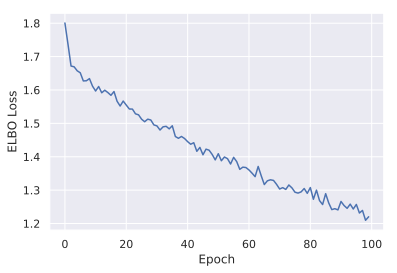

In [28]:
# Plot the ELBO loss
plt.plot(elbo1)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

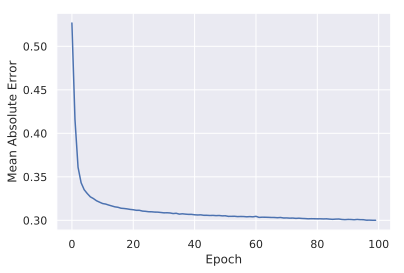

In [29]:
# Plot validation error over training
plt.plot(mae1)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

The Bayesian network does pretty well, about as well as the non-Bayesian network!

However, there's one problem with the model: it assumes a constant level of uncertainty.  That is, the standard deviation parameter doesn't change depending on the input data - it's just fit to model the *average* level of uncertainty.  To fix that problem, and create a network which more dynamically updates its uncertainty estimates, we'll build a dual-headed Bayesian network which predicts both the mean *and* the standard deviation of the predictive distribution.

## Dual-headed Bayesian Density Network

To allow our Bayesian network to predict both the value of the target and the uncertainty as to that value, we'll give the network two "heads", or endpoints of the network.  One head will predict the mean of the predictive distribution (the network's best guess), while the other head will predict the standard deviation of the predictive distribution (how much uncertainty is behind that guess).

![Dual headed net](http://drive.google.com/uc?export=view&id=1MPspM2UhxEziX924MWX8RmGe6Sk1ovg8)

Having defined the `BayesianDenseNetwork` class (in the previous section), it's relatively easy to define another class which implements the dual-headed Bayesian density network: we can just define a core network consisting of several layers, and then two sub-networks which receive the output of the core network and output independent predictions.  The output of one network we'll use as the mean predictions, and the output of the other as the standard deviation predictions.

In [30]:
class BayesianDensityNetwork(tf.keras.Model):
    """Multilayer fully-connected Bayesian neural network, with
    two heads to predict both the mean and the standard deviation.
    
    Parameters
    ----------
    units : List[int]
        Number of output dimensions for each layer
        in the core network.
    units : List[int]
        Number of output dimensions for each layer
        in the head networks.
    name : None or str
        Name for the layer
    """
    
    
    def __init__(self, units, head_units, name=None):
        
        # Initialize
        super(BayesianDensityNetwork, self).__init__(name=name)
        
        # Create sub-networks
        self.core_net = BayesianDenseNetwork(units)
        self.loc_net = BayesianDenseNetwork([units[-1]]+head_units)
        self.std_net = BayesianDenseNetwork([units[-1]]+head_units)

    
    def call(self, x, sampling=True):
        """Pass data through the model
        
        Parameters
        ----------
        x : tf.Tensor
            Input data
        sampling : bool
            Whether to sample parameter values from their variational
            distributions (if True, the default), or just use the
            Maximum a Posteriori parameter value estimates (if False).
            
        Returns
        -------
        preds : tf.Tensor of shape (Nsamples, 2)
            Output of this model, the predictions.  First column is
            the mean predictions, and second column is the standard
            deviation predictions.
        """
        
        # Pass data through core network
        x = self.core_net(x, sampling=sampling)
        x = tf.nn.relu(x)
        
        # Make predictions with each head network
        loc_preds = self.loc_net(x, sampling=sampling)
        std_preds = self.std_net(x, sampling=sampling)
        std_preds = tf.nn.softplus(std_preds)
        
        # Return mean and std predictions
        return tf.concat([loc_preds, std_preds], 1)
    
    
    def log_likelihood(self, x, y, sampling=True):
        """Compute the log likelihood of y given x"""
        
        # Compute mean and std predictions
        preds = self.call(x, sampling=sampling)
        
        # Return log likelihood of true data given predictions
        return tfd.Normal(preds[:,0], preds[:,1]).log_prob(y[:,0])
        
        
    @tf.function
    def sample(self, x):
        """Draw one sample from the predictive distribution"""
        preds = self.call(x)
        return tfd.Normal(preds[:,0], preds[:,1]).sample()
    
    
    def samples(self, x, n_samples=1):
        """Draw multiple samples from the predictive distribution"""
        samples = np.zeros((x.shape[0], n_samples))
        for i in range(n_samples):
            samples[:,i] = self.sample(x)
        return samples
    
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return (self.core_net.losses +
                self.loc_net.losses +
                self.std_net.losses)

Now we can instantiate the dual-headed model:

In [31]:
# Instantiate the model
model2 = BayesianDensityNetwork([7, 256, 128], [64, 32, 1])

Again we'll use the same optimizer and learning rate as before:

In [32]:
# Use the Adam optimizer
optimizer = tf.keras.optimizers.Adam(lr=L_RATE)

And again we'll define a `tf.function` to perform one training step.

In [33]:
N = x_train.shape[0]

@tf.function
def train_step(x_data, y_data):
    with tf.GradientTape() as tape:
        log_likelihoods = model2.log_likelihood(x_data, y_data)
        kl_loss = model2.losses
        elbo_loss = kl_loss/N - tf.reduce_mean(log_likelihoods)
    gradients = tape.gradient(elbo_loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))
    return elbo_loss

And then we can train the model!

In [34]:
%%time

# Fit the model
elbo2 = np.zeros(EPOCHS)
mae2 = np.zeros(EPOCHS)
for epoch in range(EPOCHS):
    
    # Update weights each batch
    for x_data, y_data in data_train:
        elbo2[epoch] = train_step(x_data, y_data)
        
    # Evaluate performance on validation data
    for x_data, y_data in data_val:
        y_pred = model2(x_data, sampling=False)[:, 0]
        mae2[epoch] = mean_absolute_error(y_pred, y_data)

CPU times: user 10min 28s, sys: 2min 21s, total: 12min 50s
Wall time: 8min 37s


Let's take a look at the loss and mean absolute error over the course of training.  Note that we wouldn't expect the ELBO loss to be on quite the same scale as with the previous network - the networks have slightly different numbers of parameters.

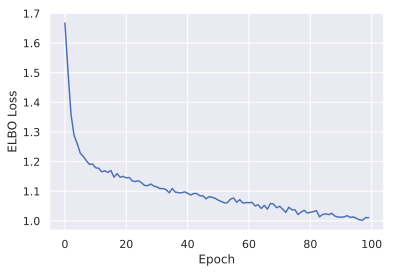

In [35]:
# Plot the ELBO Loss over training
plt.plot(elbo2)
plt.xlabel('Epoch')
plt.ylabel('ELBO Loss')
plt.show()

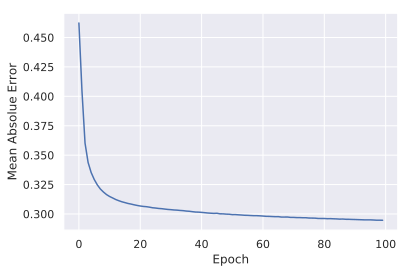

In [36]:
# Plot error over training
plt.plot(mae2)
plt.xlabel('Epoch')
plt.ylabel('Mean Absolue Error')
plt.show()

## Model Evaluation

Let's compare the three models we trained in terms of their predictive performance, and also in terms of the accuracy of their uncertainty estimates.

### Learning Curves

The three models do roughly the same in terms of predictive performance.  The dual-headed density network looks to have a slightly lower error, if anything.

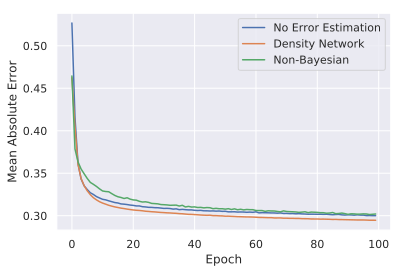

In [37]:
# Plot error vs epoch curves for all 3 models
plt.plot(mae1, label='No Error Estimation')
plt.plot(mae2, label='Density Network')
plt.plot(history.history['val_loss'], label='Non-Bayesian')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.show()

### Residuals

The distributions of the residuals (the differences between the true values and the predicted values) look about the same between the simple Bayesian network and the dual-headed density network.  This makes sense given that the parts of each network which are predicting the means are actually identical (in terms of network structure, not the weights).

Text(0, 0.5, 'Count')

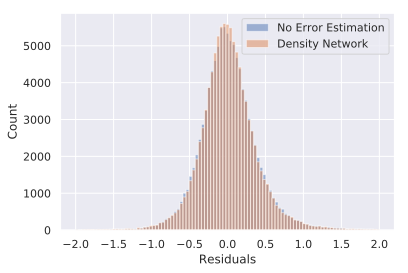

In [38]:
# Make predictions on validation data
for x_data, y_data in data_val:
    resids1 = y_data[:, 0] - model1(x_data, sampling=False)[:, 0]
    resids2 = y_data[:, 0] - model2(x_data, sampling=False)[:, 0]
    
# Plot residual distributions
bins = np.linspace(-2, 2, 100)
plt.hist(resids1.numpy(), bins, alpha=0.5,
         label='No Error Estimation')
plt.hist(resids2.numpy(), bins, alpha=0.5,
         label='Density Network')
plt.legend()
plt.xlabel('Residuals')
plt.ylabel('Count')

### Predictive Distributions

What do the two models' predictive distributions look like?  We can draw samples from the predictive distributions using the `samples` method we added to the `BayesianDenseRegression` class:

In [39]:
%%time

# Sample from predictive distributions
for x_data, y_data in data_val:
    samples1 = model1.samples(x_data, 1000)
    samples2 = model2.samples(x_data, 1000)

CPU times: user 41.7 s, sys: 36.6 s, total: 1min 18s
Wall time: 1min 21s


Let's plot the true values against the predictive distributions for both networks.  In the plots below, each panel is a single validation sample (a single taxi ride!), the dotted gray line is the true value, the blue distribution is the predictive distribution of the simple Bayesian net, and the orange distribution is the predictive distribution of the dual-headed density network.

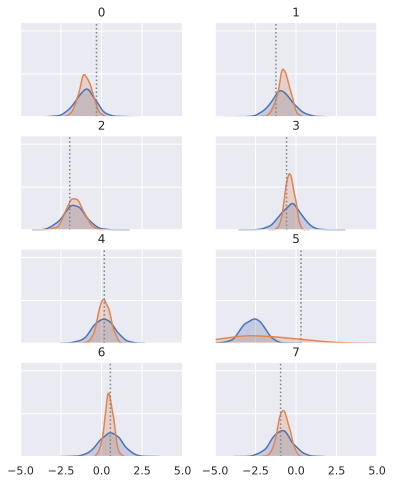

In [40]:
# Plot predictive distributions
plt.figure(figsize=(6.4, 8))
for i in range(8):
    plt.subplot(4,2,i+1)
    sns.kdeplot(samples1[i,:], shade=True)
    sns.kdeplot(samples2[i,:], shade=True)
    plt.axvline(y_data.numpy()[i], ls=':', color='gray')
    plt.xlim([-5, 5])
    plt.ylim([0, 2.2])
    plt.title(str(i))
    plt.gca().get_yaxis().set_ticklabels([])
    if i<6:
        plt.gca().get_xaxis().set_ticklabels([])

Notice how the dual-headed density network (orange) varies its uncertainty estimates, unlike the model which doesn't estimate uncertainty (blue).  For example, in the upper-left panel, the density network is much more certain of its estimate than the other model, and its predictive distribution is much sharper.  Though for other datapoints, like that in panel 5, the density network is *less* certain of its estimate, and the predictive distribution is wider.  And sometimes both models have similar levels of uncertainty, like in the lower-right panel.

### Coverage of the 95% Confidence Interval

To measure how accurate the uncertainty predictions are, we can compute the coverage of the 95% predictive interval.  If our uncertainty estimates are perfect, we would expect exactly 95% of samples to fall within the inner 95% of the predictive distribution.  The "coverage" of the 95% interval measures what percentage of samples actually do fall within that range, and so the coverage should be around 95%.

Let's make a function to compute the coverage of a given predictive interval, and then measure the coverage of the 95% interval for both the simple Bayesian network, and the dual-headed density network.

In [41]:
%%time

def covered(samples, y_true, prc=95.0):
    """Whether each sample was covered by its predictive interval"""
    q0 = (100.0-prc)/2.0 #lower percentile 
    q1 = 100.0-q0        #upper percentile
    within_conf_int = np.zeros(len(y_true))
    for i in range(len(y_true)):
        p0 = np.percentile(samples[i,:], q0)
        p1 = np.percentile(samples[i,:], q1)
        if p0<=y_true[i] and p1>y_true[i]:
            within_conf_int[i] = 1
    return within_conf_int

# Compute what samples are covered by their 95% predictive intervals
covered1 = covered(samples1, y_data)
covered2 = covered(samples2, y_data)

CPU times: user 8min 31s, sys: 1min 31s, total: 10min 2s
Wall time: 7min 27s


How do they compare?  Again, we want these values to be as close to 95.0% as possible.

In [42]:
print('No Unc Estimation: ', 100*np.mean(covered1))
print('Density Network: ', 100*np.mean(covered2))

No Unc Estimation:  98.43159194382282
Density Network:  95.12404506520565


Looks like the simple network doesn't have quite as ideal a coverage as the dual-headed network.  Its coverage percentage is too high, meaning the simple network is *under*confident in its predictions.  Generally speaking though, I wouldn't expect one or the other network to have a worse coverage *overall*.  The advantage of the dual-headed network is that it can make uncertainty predictions which change dynamically as the input features change.  So, let's take a look at the coverage of the 95% predictive interval as a function of some feature, say, the hour of the day.

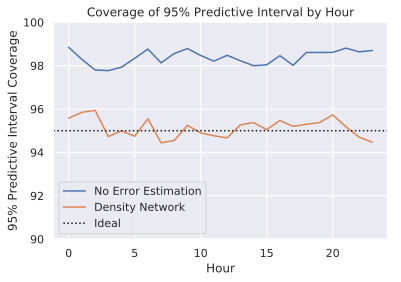

In [43]:
# Compute hour of the day
hour = x_data[:,4].numpy()
hour = hour-hour.min()
hour = hour/hour.max()
hour = np.floor(23.99*hour)

# Compute coverage as a fn of time of day
covs1 = np.zeros(24)
covs2 = np.zeros(24)
for iT in range(0,24):
    ix = hour==iT
    covs1[iT] = 100.0*np.mean(covered1[ix])
    covs2[iT] = 100.0*np.mean(covered2[ix])
    
# Plot coverage as a fn of time of day
plt.plot(covs1, label='No Error Estimation')
plt.plot(covs2, label='Density Network')
plt.axhline(95.0, label='Ideal', ls=':', color='k')
plt.xlabel('Hour')
plt.ylabel('95% Predictive Interval Coverage')
plt.title('Coverage of 95% Predictive Interval by Hour')
plt.ylim([90, 100])
plt.legend()
plt.show()

Neither network seems to be drastically over- or under-estimating uncertainty as the time of day changes, though again the simple network overestimates uncertainty overall.

Let's also take a look at the coverage of the 95% predictive interval as a function of the pickup location.  First, for the simple network:

Text(0.5, 1.0, 'No Error Estimation')

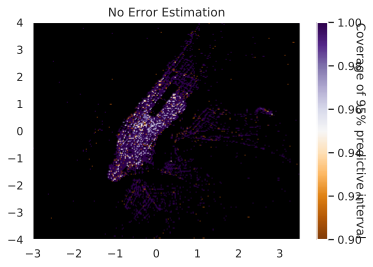

In [44]:
# Create vaex df with predictive intervals
cov_by_loc = pd.DataFrame()
cov_by_loc['x'] = x_data[:, 0].numpy()
cov_by_loc['y'] = x_data[:, 1].numpy()
cov_by_loc['covered'] = covered1
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
lims = [[-3, 3.5],[-4, 4]]
cov = vdf.mean(vdf.covered, limits=lims, shape=250,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
cmap = matplotlib.cm.PuOr
cmap.set_bad('black', 1.)
plt.imshow(cov.T, origin='lower', aspect='auto',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('No Error Estimation')

And then for the dual-headed density network:

Text(0.5, 1.0, 'Density Network')

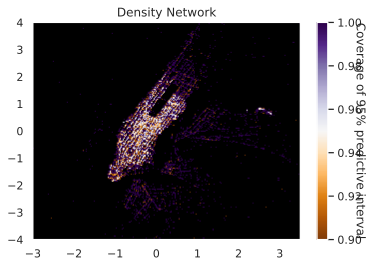

In [45]:
# Create vaex df with predictive intervals
cov_by_loc['covered'] = covered2
vdf = vaex.from_pandas(cov_by_loc)

# Compute coverage of the predictive interval
cov = vdf.mean(vdf.covered, limits=lims, shape=250,
               binby=[vdf.x,
                      vdf.y])

# Plot coverage of the predictive interval
plt.imshow(cov.T, origin='lower', aspect='auto',
           vmin=0.9, vmax=1.0, cmap=cmap,
           extent=[lims[0][0], lims[0][1], 
                   lims[1][0], lims[1][1]])
ax = plt.gca()
ax.grid(False)
cbar = plt.colorbar()
cbar.set_label('Coverage of 95% predictive interval', 
               rotation=270)
plt.title('Density Network')